读取文件 导入数据

In [41]:
import pandas as pd
import numpy as np
df = pd.read_csv("./PRSA_data.csv")

drop NA

In [42]:
df = df.dropna(subset=['pm2.5'])
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


筛选日期

实现蔡勒公式

In [43]:
import math


def determine_test(year,  month, day):
    year = year-2000
    c = 20
    w = 0    
    if month == 1:
        month = 13
        year = year-1
    if month == 2:
        month = 14
        year = year-1
    w = year + math.floor(year/4) + math.floor(c/4) -2*c +math.floor(26*(month+1)/10) + day -1
    if w%7 == 4 :
        return 1
    else:
        return 0

        
    

In [44]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'cbwd', 'Iws', 'Is', 'Ir'],
      dtype='object')

In [45]:
real_number_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
for col in real_number_cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,DEWP_zscore,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,-1.229791,-1.347143,0.345329,-0.444944,-0.071057,-0.137408
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,-1.160508,-1.347143,0.345329,-0.427007,-0.071057,-0.137408
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,-0.883375,-1.429278,0.442411,-0.409069,-0.071057,-0.137408
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,-0.606241,-1.429278,0.539493,-0.372993,1.212862,-0.137408
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,-0.606241,-1.429278,0.539493,-0.355055,2.496781,-0.137408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0,-1.714775,-1.182873,1.704472,4.194201,-0.071057,-0.137408
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0,-1.645491,-1.265008,1.704472,4.311298,-0.071057,-0.137408
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0,-1.645491,-1.265008,1.704472,4.410458,-0.071057,-0.137408
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0,-1.645491,-1.347143,1.704472,4.491479,-0.071057,-0.137408


In [46]:
df_dummy = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df,df_dummy], axis=1).drop(columns=['cbwd'])

df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,DEWP_zscore,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,...,-1.229791,-1.347143,0.345329,-0.444944,-0.071057,-0.137408,0,0,1,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,...,-1.160508,-1.347143,0.345329,-0.427007,-0.071057,-0.137408,0,0,1,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,...,-0.883375,-1.429278,0.442411,-0.409069,-0.071057,-0.137408,0,0,1,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,...,-0.606241,-1.429278,0.539493,-0.372993,1.212862,-0.137408,0,0,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,...,-0.606241,-1.429278,0.539493,-0.355055,2.496781,-0.137408,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,...,-1.714775,-1.182873,1.704472,4.194201,-0.071057,-0.137408,0,1,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,...,-1.645491,-1.265008,1.704472,4.311298,-0.071057,-0.137408,0,1,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,...,-1.645491,-1.265008,1.704472,4.410458,-0.071057,-0.137408,0,1,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,...,-1.645491,-1.347143,1.704472,4.491479,-0.071057,-0.137408,0,1,0,0


筛选

In [47]:
df['test'] =df.apply(lambda x: determine_test(x['year'],x['month'],x['day']), axis=1)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,test
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,...,-1.347143,0.345329,-0.444944,-0.071057,-0.137408,0,0,1,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,...,-1.347143,0.345329,-0.427007,-0.071057,-0.137408,0,0,1,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,...,-1.429278,0.442411,-0.409069,-0.071057,-0.137408,0,0,1,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,...,-1.429278,0.539493,-0.372993,1.212862,-0.137408,0,0,1,0,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,...,-1.429278,0.539493,-0.355055,2.496781,-0.137408,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,231.97,...,-1.182873,1.704472,4.194201,-0.071057,-0.137408,0,1,0,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,237.78,...,-1.265008,1.704472,4.311298,-0.071057,-0.137408,0,1,0,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,242.70,...,-1.265008,1.704472,4.410458,-0.071057,-0.137408,0,1,0,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,246.72,...,-1.347143,1.704472,4.491479,-0.071057,-0.137408,0,1,0,0,0


In [48]:
test = df.loc[df['test'] == 1]
train = df.loc[df['test'] == 0]
test

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,...,TEMP_zscore,PRES_zscore,Iws_zscore,Is_zscore,Ir_zscore,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,test
144,145,2010,1,7,0,127.0,-21,-16.0,1035.0,8.95,...,-2.332764,1.801554,-0.300638,-0.071057,-0.137408,0,1,0,0,1
145,146,2010,1,7,1,130.0,-21,-16.0,1035.0,0.45,...,-2.332764,1.801554,-0.471951,-0.071057,-0.137408,0,0,0,1,1
146,147,2010,1,7,2,43.0,-22,-18.0,1036.0,1.34,...,-2.497034,1.898636,-0.454014,-0.071057,-0.137408,0,0,0,1,1
147,148,2010,1,7,3,37.0,-23,-15.0,1036.0,4.02,...,-2.250629,1.898636,-0.400000,-0.071057,-0.137408,0,1,0,0,1
148,149,2010,1,7,4,30.0,-24,-16.0,1035.0,7.15,...,-2.332764,1.801554,-0.336916,-0.071057,-0.137408,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,43676,2014,12,25,19,49.0,-11,-1.0,1032.0,2.67,...,-1.100738,1.510309,-0.427208,-0.071057,-0.137408,0,0,0,1,1
43676,43677,2014,12,25,20,52.0,-11,-2.0,1032.0,1.79,...,-1.182873,1.510309,-0.444944,-0.071057,-0.137408,0,0,1,0,1
43677,43678,2014,12,25,21,50.0,-11,0.0,1033.0,0.89,...,-1.018603,1.607391,-0.463083,-0.071057,-0.137408,0,0,0,1,1
43678,43679,2014,12,25,22,51.0,-12,-3.0,1033.0,0.89,...,-1.265008,1.607391,-0.463083,-0.071057,-0.137408,0,0,1,0,1


In [49]:
df.columns

Index(['No', 'year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES',
       'Iws', 'Is', 'Ir', 'DEWP_zscore', 'TEMP_zscore', 'PRES_zscore',
       'Iws_zscore', 'Is_zscore', 'Ir_zscore', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'test'],
      dtype='object')

In [50]:
name_feature_z_score=['DEWP_zscore', 'TEMP_zscore', 'PRES_zscore',
       'Iws_zscore', 'Is_zscore', 'Ir_zscore']
name_cbwd=['cbwd_NE', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv']

线性回归 岭回归 LASSO回归

In [51]:
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV

linear_model = LinearRegression()
linear_model.fit(train.loc[:,name_feature_z_score+name_cbwd],train.loc[:,'pm2.5'])
r2_lm = linear_model.score(test.loc[:,name_feature_z_score+name_cbwd],test.loc[:,'pm2.5'])
r2_lm

0.2763404591391191

In [52]:
lm_result = pd.DataFrame(data = list(zip(df.iloc[:,6:16].columns,linear_model.coef_)), columns=['特征','特征对应系数'])
lm_result

,特征,特征对应系数
0,DEWP,5.710586e+01
1,TEMP,-7.562250e+01
2,PRES,-1.727377e+01
3,Iws,-1.083016e+01
4,Is,-2.186279e+00
5,Ir,-8.910703e+00
6,DEWP_zscore,-1.981848e+13
7,TEMP_zscore,-1.981848e+13
8,PRES_zscore,-1.981848e+13
9,Iws_zscore,-1.981848e+13


In [60]:
alphas = np.linspace(1,1000,1000)
ridge_model = RidgeCV(alphas=alphas)
ridge_model.fit(train.loc[:,name_feature_z_score],train.loc[:,'pm2.5'],train.loc[:,'pm2.5'])
r2_ridge = ridge_model.score(test.loc[:,name_feature_z_score],test.loc[:,'pm2.5'])
r2_ridge,ridge_model.alpha_



(-0.23589257980807243, 324.0)

In [54]:
alphas = np.linspace(1,100,100)
lasso_model = LassoCV(alphas=alphas)
lasso_model.fit(train.loc[:,name_feature_z_score+name_cbwd],train.loc[:,'pm2.5'])
r2_lasso = lasso_model.score(test.loc[:,name_feature_z_score+name_cbwd],test.loc[:,'pm2.5'])
r2_lasso,lasso_model.alpha_

(0.2698423765567024, 1.0)

<AxesSubplot:>

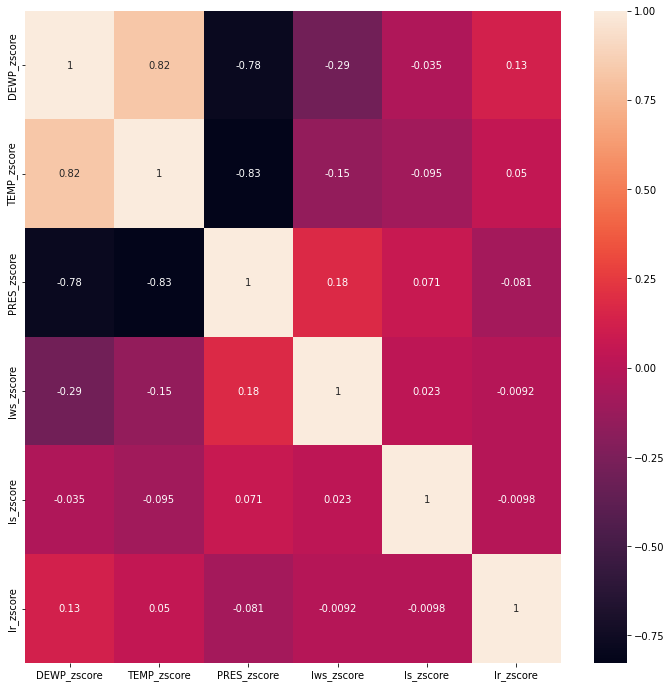

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = df.loc[:,name_feature_z_score].corr()
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_df,annot = True)

In [58]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

tree_model = DecisionTreeRegressor()
tree_model.fit(train.loc[:,name_feature_z_score+name_cbwd],train.loc[:,'pm2.5'])

r2 = r2_score(tree_model.predict(test.loc[:,name_feature_z_score+name_cbwd]),test.loc[:,'pm2.5'])
r2


-0.2252643985970788

In [1]:
import tensorflow